In [1]:

DIST_PATH = 'evaluation/dtw/userAcceleration-y_distances.npy'
DATA_PATH = 'data/motionsense.csv'
FIG_FOLDER = 'data/figures/'

In [2]:
# TODO: procurar nomes melhores
CLASS_MAP = ["dws","ups", "wlk", "jog", "std", "sit"]

In [95]:
COL = 'userAcceleration.y'
LABEL = 'sit'

# Carregando distâncias e rótulos

In [96]:
import pandas as pd
import numpy as np
from scripts.compute_distances import get_series

In [97]:
data_df = pd.read_csv(DATA_PATH, index_col=0)

In [98]:
X, labels = get_series(data_df, COL) # da para passar qualquer coluna aqui, estamos apenas interessados nos labels

In [99]:
# convertendo ids para labels strings
labels = np.array([CLASS_MAP[int(i)] for i in labels])

In [100]:
distances = np.load(DIST_PATH)

# Agregando distâncias com base nos rótulos

In [101]:
def agregate_distances_by_label(target_label: int, distances: np.array, labels: np.array):

    distances_by_label = {}
    same_label_ids = np.where(labels == target_label)[0]

    for label in np.unique(labels):

        different_label_ids = np.where(labels == label)[0]

        # talvez exista uma forma de fazer isso melhor
        distances_by_label[label] = []
        for same_label_id in same_label_ids:
            for different_label_id in different_label_ids:
                curr_dist = distances[same_label_id, different_label_id]
                # ignorar distancias 0 (exemplo para ele mesmo)
                if curr_dist != 0:
                    distances_by_label[label].append(distances[same_label_id, different_label_id])

    return distances_by_label

In [102]:
distance_dict = agregate_distances_by_label(LABEL, distances, labels)

# Preparando plot

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [104]:
def plot_distances_by_label(distance_dict: dict, label: str):

    all_distances = np.concatenate([dists for dists in distance_dict.values()])
    all_labels = np.concatenate([[label] * len(dists) for label, dists in distance_dict.items()])


    ax = sns.boxplot(y=all_distances, x=all_labels, palette='tab10', hue=all_labels, legend=False)
    plt.suptitle(f"Distâncias entre a classe '{label}' e as outras classes")
    ax.set(xlabel='Classe', ylabel='Distância')
    # TODO: salvar a figurinha

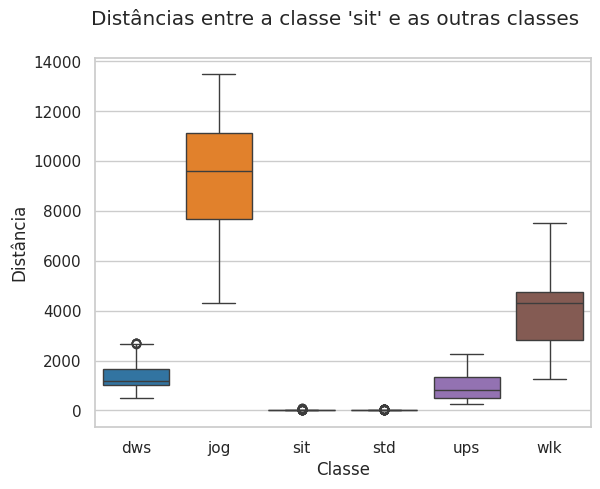

In [105]:
distance_dict = agregate_distances_by_label(LABEL, distances, labels)
plot_distances_by_label(distance_dict, LABEL)
plt.savefig(f"{FIG_FOLDER}{LABEL}_vs_all.pdf", bbox_inches='tight')

# Determinando pares de séries mais semelhantes e diferentes por label

In [106]:
import matplotlib.pyplot as plt

In [107]:
import pandas as pd

def calculate_moving_average(series: np.array, window: int = 10) -> np.array:

    series = pd.Series(series)
    moving_average = series.rolling(window).mean()

    return moving_average.values

def calculate_exponential_moving_average(series: np.array, window: int = 10) -> np.array:

    series = pd.Series(series)
    moving_average = series.ewm(span=window, adjust=False).mean()

    return moving_average.values


In [108]:
def standardize_series(series: np.array) -> np.array:
    
    mean = series.mean()
    std = series.std()

    return (series - mean) / std

def get_pair(distances: np.array, label: str, most_similar: bool = True) -> tuple[int, int]:

    if most_similar:
        # distancia 0 para o proprio exemplo não tem graça
        distances = distances.copy()
        distances[distances == 0.0] = np.inf

    label_ids =  np.where(labels == label)[0]
    label_distances = distances[label_ids][:,label_ids]
    print(f'- Min: {label_distances.min()}')
    print(f'- Max: {label_distances.max()}')

    # recuperando ids dentro da mesma classe
    i, j = np.unravel_index(label_distances.argmin() if most_similar else label_distances.argmax(), label_distances.shape)
    # mapeando para os ids originais
    return label_ids[j], label_ids[i]

def plot_pair_of_series(distances: np.array, X: list, label: str, most_similar: bool = True, window: int = 10, offset: int = 2, standardize: bool = False):

    plt.suptitle(f"Séries {'mais' if most_similar else 'menos'} similares da classe '{label}'.")

    i, j = get_pair(distances, label, most_similar)

    # plt.plot(calculate_moving_average(standardize_series(X[i]) if standardize else X[i], window=window))
    # plt.plot(calculate_moving_average(standardize_series(X[j]) if standardize else X[j], window=window) + offset)
    
    plt.plot(standardize_series(X[i]) if standardize else X[i])
    plt.plot(standardize_series(X[j]) if standardize else X[j] + offset)


- Min: 0.41076078314400466
- Max: inf


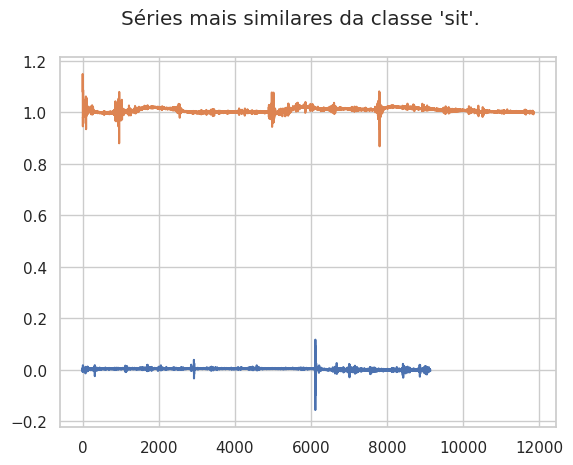

In [113]:
plot_pair_of_series(distances, X, LABEL, most_similar=True, window=1, offset=1, standardize=False)
plt.savefig(f"{FIG_FOLDER}{LABEL}_most_similar.pdf", bbox_inches='tight')

- Min: 0.0
- Max: 80.92911060880895


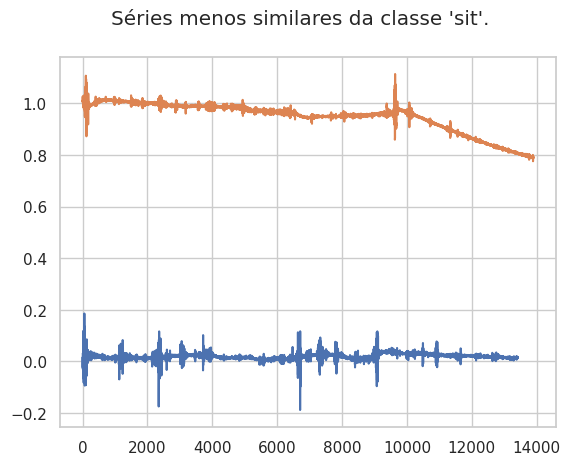

In [110]:
plot_pair_of_series(distances, X, LABEL, most_similar=False, window=1, offset=1)

# Visualização do caminho DTW

In [111]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

- Min: 0.41076078314400466
- Max: inf


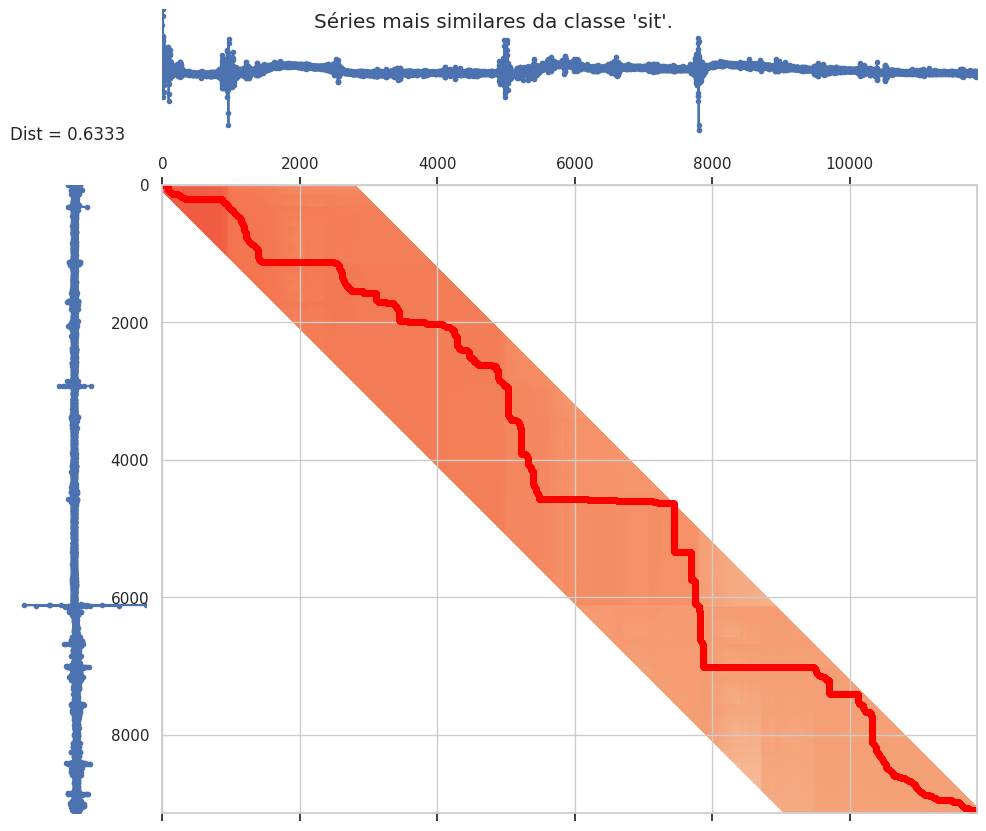

In [112]:
i, j = get_pair(distances, LABEL, most_similar=True)
s1 = X[i]
s2 = X[j]

d, paths = dtw.warping_paths(s1, s2, window=100, psi=2)
best_path = dtw.best_path(paths)
fig = plt.figure(figsize=(10,10))
fig, axes = dtwvis.plot_warpingpaths(s1, s2, paths, best_path, figure=fig)
fig.suptitle(f"Séries mais similares da classe '{LABEL}'.")
plt.savefig(f"{FIG_FOLDER}{LABEL}_most_similar_warping_path.pdf", bbox_inches='tight')